In [1]:
import cobra
import sys
import pandas as pd
import numpy as np
import plotly.express
import matplotlib.pyplot as plt

# Load PAMpy modules

In [2]:
# load PAMpy modules
sys.path.append('../Package/')
from PAModel import PAModel
from EnzymeSectors import ActiveEnzymeSector, UnusedEnzymeSector, TransEnzymeSector
from PAMValidator import PAMValidator

# Set-up E.coli core proteome allocation model (PAM)

## 1. load E.coli core model

In [3]:
# load the model
model = cobra.io.load_json_model('../models/e_coli_core.json')
# test the model
sol_t = model.optimize()
print(model.summary())

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-07
Objective
1.0 BIOMASS_Ecoli_core_w_GAM = 0.8739215069684301

Uptake
------
Metabolite    Reaction  Flux  C-Number  C-Flux
  glc__D_e EX_glc__D_e    10         6 100.00%
     nh4_e    EX_nh4_e 4.765         0   0.00%
      o2_e     EX_o2_e  21.8         0   0.00%
      pi_e     EX_pi_e 3.215         0   0.00%

Secretion
---------
Metabolite Reaction   Flux  C-Number  C-Flux
     co2_e EX_co2_e -22.81         1 100.00%
     h2o_e EX_h2o_e -29.18         0   0.00%
       h_e   EX_h_e -17.53         0   0.00%



## 2. Convert core model to PAM

### 2.1 Create Proteome Sectors

#### 2.1.1. Active Enzymes

In [4]:
# load enzyme database from genome-scale E. coli PAM
enzyme_db = pd.read_excel('../data/proteinAllocationModel_iML1515_EnzymaticData_py.xls',
                          sheet_name='ActiveEnzymes', index_col=0)

# correct reaction IDS
for idx in enzyme_db.index.to_list():
    # transprt reactions<
    
    if 'pp' in idx:
        idx_new = idx.replace('pp', '')
        if idx_new not in enzyme_db.index:
            enzyme_db.rename(index={idx: idx_new}, inplace=True)
    if 'ex' in idx:
        idx_new = idx.replace('ex', '')
        if idx_new not in enzyme_db.index:
            enzyme_db.rename(index={idx: idx_new}, inplace=True)    

enzyme_db

,rxnName,rxnEquat,EC_nmbr,molMass,kcat
rxnID,,,,,
ALATA_D2,D-alanine transaminase,pydx5p_c + ala__D_c -> pyam5p_c + pyr_c,"2.1.2.1, 4.1.2.48",40904.4850,6.862500e+00
SHCHD2,Sirohydrochlorin dehydrogenase (NAD),nad_c + dscl_c -> h_c + scl_c + nadh_c,1.3.1.76,49950.0000,4.500000e-01
CPPPGO,Coproporphyrinogen oxidase (O2 required),2 h_c + o2_c + cpppg3_c -> 2 h2o_c + pppg9_c ...,1.3.3.3,34321.4900,3.000000e-03
GTHOr_f,Glutathione oxidoreductase,h_c + nadph_c + gthox_c -> 2 gthrd_c + nadp_c,1.8.1.7,48771.0500,7.333000e+02
DHORD5,Dihydroorotic acid (menaquinone-8),dhor__S_c + mqn8_c -> orot_c + mql8_c,1.3.5.2,36773.4600,8.200000e+01
...,...,...,...,...,...
AI2t_b,"Ai2 transport, outer membrane",mththf_p -> mththf_e,NaN,39959.4825,2.200000e+01
RHMND_b,L-rhamnonate dehydratase,lkdr_c + h2o_c -> rhmn_c,4.2.1.90,44225.1000,2.000000e-02
ASPtpp_b,L-aspartate uptake via facillitated diffusion,asp__L_c -> asp__L_p,NaN,59427.5800,1.000000e+08


In [5]:
#replace NaN enzyme ids with a dummy enzyme identifier
#select the NaN values 
nan_values = enzyme_db['EC_nmbr'].isnull()
#make a list with unique ids
nan_ids = [f'E{i}' for i in range(nan_values.sum())]
#replace nan values by unique id
enzyme_db.loc[nan_values, 'EC_nmbr'] = nan_ids

#check if it worked:
enzyme_db[nan_values]

,rxnName,rxnEquat,EC_nmbr,molMass,kcat
rxnID,,,,,
GLUt_f,L-glutamate transport via diffusion (extracell...,glu__L_e -> glu__L_p,E0,39959.4825,100000000.0
GLYt_f,Glycine transport via diffusion (extracellular...,gly_e -> gly_p,E1,39959.4825,100000000.0
GLYALDt_f,Glyceraldehyde transport via diffusion (extrac...,glyald_e -> glyald_p,E2,39959.4825,100000000.0
GLYBt_f,Glycine betaine transport via diffusion (extra...,glyb_e -> glyb_p,E3,39959.4825,100000000.0
GLYCt_f,Glycerol transport via diffusion (extracellula...,glyc_e -> glyc_p,E4,39959.4825,100000000.0
...,...,...,...,...,...
METGLCURt_b,1-O-methyl-Beta-D-glucuronate via diffusion (e...,metglcur_p -> metglcur_e,E953,39959.4825,100000000.0
AI2t_b,"Ai2 transport, outer membrane",mththf_p -> mththf_e,E954,39959.4825,22.0
ASPtpp_b,L-aspartate uptake via facillitated diffusion,asp__L_c -> asp__L_p,E955,59427.5800,100000000.0


In [6]:
# create enzyme objects for each gene-associated reaction
kcats = {}
rxn2ec = {}
molmass = {}
for rxn in model.reactions:
    if rxn.genes:
        # correct transport reactions
        if 't' in rxn.id:
            rxn.id = rxn.id
        # are enzyme information in the PAM database?
        rev = 0 # denotes reversibility
        if rxn.lower_bound >= 0:
            # irreversible reaction (forward direction)
            rev = 0
            rxn_id = rxn.id # save reaction ID for retrieveing molar masses/enzyme information later
            if rxn.id in enzyme_db.index:
                kcats[rxn.id] = {'f': enzyme_db.loc[rxn.id, 'kcat']}
        elif rxn.upper_bound <= 0:
            # irreversible reaction (reverse direction)
            rev = 1
            rxn_id = rxn.id + '_b'
            if rxn_id in enzyme_db.index:
                kcats[rxn.id] = {'b': enzyme_db.loc[rxn_id, 'kcat']}
        else:
            rev = 2
            # reversible reaction
            rxn_id_f = rxn.id + '_f'
            rxn_id_b = rxn.id + '_b'
            if rxn_id_f in enzyme_db.index and rxn_id_b in enzyme_db.index:
                rxn_id = rxn_id_f # save reaction ID for retrieveing molar masses/enzyme information later
                kcats[rxn.id] = {'f': enzyme_db.loc[rxn_id_f, 'kcat'],
                                 'b': enzyme_db.loc[rxn_id_b, 'kcat']}

            else:
                # try if only forward reaction is in database
                rxn_id = rxn.id # save reaction ID for retrieveing molar masses/enzyme information later
                kcats[rxn.id] = {'f': enzyme_db.loc[rxn.id, 'kcat'],
                                 'b': enzyme_db.loc[rxn.id, 'kcat']/2} # deduce backwards kcat from forward value

        # where enzyme information found?
        if rxn.id in kcats.keys():
            # save molmass
            molmass[rxn.id] = enzyme_db.loc[rxn_id, 'molMass']
            #save enzyme information
            # is enzyme information NaN?
            if pd.isna(enzyme_db.loc[rxn_id, 'EC_nmbr']):
                rxn2ec[rxn.id] = ''
            else:
                rxn2ec[rxn.id] = enzyme_db.loc[rxn_id, 'EC_nmbr']
            
            
        else:
            # no enzyme information found
            print('No enzyme information found for reaction: ' + rxn.id)
            # Create generic Enzyme with mean molar masses and kcat
            if rev == 0:
                kcats[rxn.id] = {'f': 22}
            elif rev == 1: 
                kcats[rxn.id] = {'b': 22}
            else:
                kcats[rxn.id] = {'f': 22, 'b': 22}
                
            molmass[rxn.id] = 3.947778784340140e04

rxn2protein = {}
for rxn, ec in rxn2ec.items():
    ec_dict = {**kcats[rxn], **{'molmass': molmass[rxn]}}
    #add enzyme to enzymes related to reaction if these are already stored
    if rxn in rxn2protein.keys():
        rxn2protein[rxn] = {**rxn2protein[rxn], **{ec:ec_dict}}
    #if not create new reaction entry
    else:
        rxn2protein[rxn] = {ec:ec_dict}
          


# create active enzymes sector
active_enzyme_sector = ActiveEnzymeSector(rxn2protein=rxn2protein)

No enzyme information found for reaction: FRD7


#### 2.1.2. Translational Enzyme Sector

In [7]:
# translational protein sector parameter (substrate dependent)
id_list_tps = ['EX_glc__D_e']
tps_0 = [0.04992] # g/gDW
tps_mu = [-0.002944] # g h/gDW -> transformed to match glucose uptake variable
molmass_tps = [405903.94] # g/mol

# translational protein sector
translational_enzyme_sector = TransEnzymeSector(
    id_list=id_list_tps,
    tps_0=tps_0,
    tps_mu=tps_mu,
    mol_mass  = molmass_tps,
)

#### 2.1.3.Total Protein Constraint

In [7]:
# total protein constraint (cf. analyze_proteome.ipynb)
p_tot = 0.140 # g/gDW -> Standard 0.14 g/gDW 

### 2.2. Setup PAM

In [8]:
# set up PAM
# pa_model = PAModel(
#     id_or_model=model,
#     p_tot=p_tot,
#     sensitivity = True,
#     translational_sector=translational_enzyme_sector,
#     active_sector=active_enzyme_sector,
# )
pa_model = PAModel(
    id_or_model=model,
    p_tot=p_tot,
    sensitivity = True,
    active_sector=active_enzyme_sector,
)

Read LP format model from file /tmp/tmpq2bu3sqx.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Setting up the proteome allocation model e_coli_core

Add total condition-dependent protein constraint
	Total protein concentration: 0.14 g/gDW

Add active protein sector

Done with setting up the proteome allocation model e_coli_core



/home/samiralvdb/Documents/3_Projects/6_Ecolicore/scripts/../Package/EnzymeSectors.py:224: UserWarning: FORt: reaction directionality does not match provided kcat values. Skip reaction
  warn(reaction.id + ': reaction directionality does not match provided kcat values. Skip reaction')


## 3. Sensitivity of the Ecoli core constraints

### 3.1 simulations with only active enzyme sectors for a range of glucose uptake rates

In [23]:
#some usefull functions
def print_heatmap(xaxis, yaxis, matrix, title = ''):
    fig = plotly.express.imshow(matrix, aspect="auto",
                                x = xaxis, y = yaxis,
                                labels = dict(x = 'constraint', y='glucose uptake rate [mmol/gcdw/h]'),
                               title = title)
    
    fig.update_layout(font=dict(size=20), 
                      yaxis = dict(tickfont = dict(size=20)),
                     xaxis = dict(tickfont = dict(size=8)))
#     fig.update_xaxes(title_font=dict(size=8))
#     fig.update_yaxes(title_font=dict(size=18))
    
    fig.show()
    

In [26]:
glc_uptake_rates = np.linspace(0.5, 10, 20)
Cv = []
Cc = []
Ca = []
x_axis_ac = []
x_axis_cc = []
y_axis = []

# disable pyruvate formate lyase (inhibited by oxygen)
pa_model.change_reaction_bounds(rxn_id = 'PFL', upper_bound = 0)

for glc in glc_uptake_rates:
    y_axis += [glc]
    print('glucose uptake rate ', glc, ' mmol/gcdw/h')
    with pa_model:
        # change glucose uptake rate
        pa_model.change_reaction_bounds(rxn_id = 'EX_glc__D_e', 
                                        lower_bound = -glc, upper_bound = -glc)
        # solve the model
        pa_model.optimize()
        # save data
        Cv_new = list()
#         for i, row in pa_model.control_coefficients.iterrows():
#             if row['coefficient']!=0:
#                 print(row)
                
#         for i, row in pa_model.allocation_coefficients.iterrows():
#             if row['coefficient']!=0:
#                 print(row)
                
    
        control_coeff = pa_model.control_coefficients
        for cc in ['UB', 'LB', 'EC_f', 'EC_b', 'sector']:
            Cv_new += control_coeff[control_coeff['constraint'] == cc].coefficient.to_list()
        Cv += [Cv_new]
        
        alloc_coeff = pa_model.allocation_coefficients
        Ca_new = list()
        for ac in ['rxn', 'enzyme', 'sector']:
            Ca_new += alloc_coeff[alloc_coeff['constraint'] == ac].coefficient.to_list()
        Ca += [Ca_new]

    print('Sum of control coefficients: \t \t \t \t \t \t \t \t', sum(Cv_new))
    print('Sum of allocation coefficients: \t \t \t \t \t \t \t', sum(Ca_new))

for cc in ['UB', 'LB', 'EC_f', 'EC_b', 'sector']:
    if cc == 'UB' or cc == 'LB':
        x_axis_cc += control_coeff[control_coeff['constraint'] == cc].rxn_id.to_list()
    else:
        x_axis_cc += control_coeff[
        control_coeff['constraint'] == cc].enzyme_id.to_list()

for ac in ['rxn', 'enzyme', 'sector']:
    if ac == 'rxn':
        x_axis_ac += alloc_coeff[alloc_coeff['constraint'] == ac].rxn_id.to_list()
    else:
        x_axis_ac += alloc_coeff[
            alloc_coeff['constraint'] == ac].enzyme_id.to_list()
        
#make yaxis

print_heatmap(x_axis_cc,y_axis, Cv, title = 'Control Coefficients')
print_heatmap(x_axis_ac, y_axis, Ca, title = 'Allocation Coefficients')

glucose uptake rate  0.5  mmol/gcdw/h
Sum of control coefficients: 	 	 	 	 	 	 	 	 -1.0000000000388027
Sum of allocation coefficients: 	 	 	 	 	 	 	 1.0000000000000036
glucose uptake rate  1.0  mmol/gcdw/h
Sum of control coefficients: 	 	 	 	 	 	 	 	 -1.0000000000015334
Sum of allocation coefficients: 	 	 	 	 	 	 	 1.0000000000000002
glucose uptake rate  1.5  mmol/gcdw/h
Sum of control coefficients: 	 	 	 	 	 	 	 	 -1.0000000000007505
Sum of allocation coefficients: 	 	 	 	 	 	 	 0.9999999999999998
glucose uptake rate  2.0  mmol/gcdw/h
Sum of control coefficients: 	 	 	 	 	 	 	 	 -1.0000000000005058
Sum of allocation coefficients: 	 	 	 	 	 	 	 0.9999999999999998
glucose uptake rate  2.5  mmol/gcdw/h
Sum of control coefficients: 	 	 	 	 	 	 	 	 -1.0000000000003815
Sum of allocation coefficients: 	 	 	 	 	 	 	 0.9999999999999999
glucose uptake rate  3.0  mmol/gcdw/h
Sum of control coefficients: 	 	 	 	 	 	 	 	 -1.0000000000003062
Sum of allocation coefficients: 	 	 	 	 	 	 	 0.999999999

In [27]:
#without glc uptake and atp maintenance
glc_uptake_rates = np.linspace(0.5, 10, 20)
Cv_wo = []
Cc_wo = []
Ca_wo = []
Cc_glc = []
Ca_glc = []
Cc_atpm = []
Ca_atpm = []
x_axis_ac = []
x_axis_cc = []
y_axis = []

# disable pyruvate formate lyase (inhibited by oxygen)
pa_model.change_reaction_bounds(rxn_id = 'PFL', upper_bound = 0)

for glc in glc_uptake_rates:
    print('glucose uptake rate ', glc, ' mmol/gcdw/h')
    y_axis += [glc]
    with pa_model:
        # change glucose uptake rate
        pa_model.change_reaction_bounds(rxn_id = 'EX_glc__D_e', 
                                        lower_bound = -glc, upper_bound = -glc)
        # solve the model
        pa_model.optimize()
        # save data
        Cv_new = list()
#         for i, row in pa_model.control_coefficients.iterrows():
#             if row['coefficient']!=0:
#                 print(row)
                
#         for i, row in pa_model.allocation_coefficients.iterrows():
#             if row['coefficient']!=0:
#                 print(row)
                
        cc_glc = pa_model.control_coefficients[pa_model.control_coefficients['rxn_id'] == 'EX_glc__D_e']
        cc_atp = control_coeff[control_coeff['rxn_id'] == 'ATPM']
        control_coeff = pa_model.control_coefficients.drop(cc_glc.index)
        
        cc_atpm = control_coeff[control_coeff['rxn_id'] == 'ATPM']
        control_coeff = control_coeff.drop(cc_atpm.index)
        
        Cc_glc += [cc_glc['coefficient'].values[1]]
        Cc_atpm += [cc_atpm['coefficient'].values[1]]
        
        for cc in ['UB', 'LB', 'EC_f', 'EC_b', 'sector']:
            Cv_new += control_coeff[control_coeff['constraint'] == cc].coefficient.to_list()
        Cv_wo += [Cv_new]
        
        
        ca_glc = pa_model.allocation_coefficients[pa_model.allocation_coefficients['rxn_id'] == 'EX_glc__D_e']
        alloc_coeff = pa_model.allocation_coefficients.drop(ca_glc.index)
        
        ca_atpm = alloc_coeff[alloc_coeff['rxn_id']=='ATPM']
        alloc_coeff = alloc_coeff.drop(ca_atpm.index)
        
        Ca_glc += [ca_glc['coefficient'].values]
        Ca_atpm += [ca_atpm['coefficient'].values]
        
        Ca_new = list()
        for ac in ['rxn', 'enzyme', 'sector']:
            Ca_new += alloc_coeff[alloc_coeff['constraint'] == ac].coefficient.to_list()
        Ca_wo += [Ca_new]

    print('Sum of control coefficients: \t \t \t \t \t \t \t \t', sum(Cv_new))
    print('Sum of allocation coefficients: \t \t \t \t \t \t \t', sum(Ca_new))

for cc in ['UB', 'LB', 'EC_f', 'EC_b', 'sector']:
    if cc == 'UB' or cc == 'LB':
        x_axis_cc += control_coeff[control_coeff['constraint'] == cc].rxn_id.to_list()
    else:
        x_axis_cc += control_coeff[
        control_coeff['constraint'] == cc].enzyme_id.to_list()

for ac in ['rxn', 'enzyme', 'sector']:
    if ac == 'rxn':
        x_axis_ac += alloc_coeff[alloc_coeff['constraint'] == ac].rxn_id.to_list()
    else:
        x_axis_ac += alloc_coeff[
            alloc_coeff['constraint'] == ac].enzyme_id.to_list()
        
#make yaxis

print_heatmap(x_axis_cc,y_axis, Cv_wo, title = 'Control Coefficients')
print_heatmap(x_axis_ac, y_axis, Ca_wo, title = 'Allocation Coefficients')


glucose uptake rate  0.5  mmol/gcdw/h
Sum of control coefficients: 	 	 	 	 	 	 	 	 0.0
Sum of allocation coefficients: 	 	 	 	 	 	 	 0.0
glucose uptake rate  1.0  mmol/gcdw/h
Sum of control coefficients: 	 	 	 	 	 	 	 	 0.0
Sum of allocation coefficients: 	 	 	 	 	 	 	 0.0
glucose uptake rate  1.5  mmol/gcdw/h
Sum of control coefficients: 	 	 	 	 	 	 	 	 0.0
Sum of allocation coefficients: 	 	 	 	 	 	 	 0.0
glucose uptake rate  2.0  mmol/gcdw/h
Sum of control coefficients: 	 	 	 	 	 	 	 	 0.0
Sum of allocation coefficients: 	 	 	 	 	 	 	 0.0
glucose uptake rate  2.5  mmol/gcdw/h
Sum of control coefficients: 	 	 	 	 	 	 	 	 0.0
Sum of allocation coefficients: 	 	 	 	 	 	 	 0.0
glucose uptake rate  3.0  mmol/gcdw/h
Sum of control coefficients: 	 	 	 	 	 	 	 	 0.0
Sum of allocation coefficients: 	 	 	 	 	 	 	 0.0
glucose uptake rate  3.5  mmol/gcdw/h
Sum of control coefficients: 	 	 	 	 	 	 	 	 0.012628686424750766
Sum of allocation coefficients: 	 	 	 	 	 	 	 0.013022371507190707
glucose

/tmp/ipykernel_7962/3455277223.py:55: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



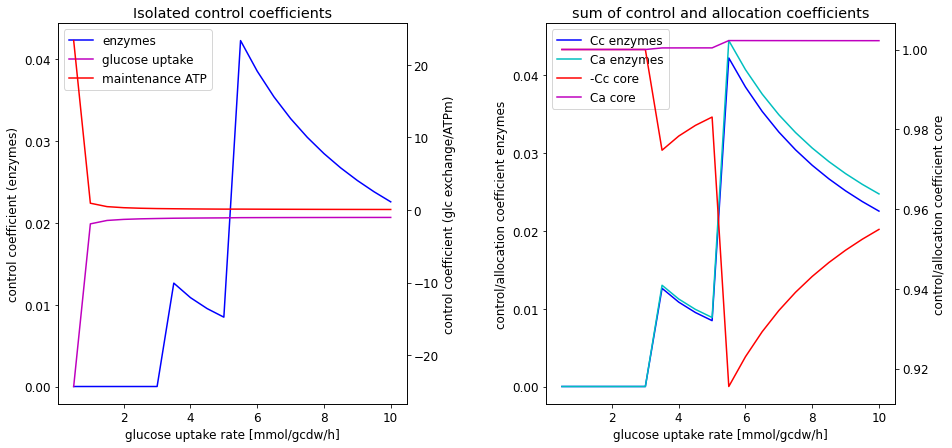

In [46]:
#plot the total sensitivity of the enzymes

Cc_sum_wo =[sum(c) for c in Cv_wo]
Ca_sum_wo =[sum(c) for c in Ca_wo]


Cc_sum =[-sum(c) for c in Cv]
Ca_sum =[sum(c) for c in Ca]

# cc_glc = cc_glc['coefficient'].to_list()
# cc_atpm = cc_atpm['coefficient'].to_list()

# ca_glc = ca_glc['coefficient'].to_list()
# ca_atpm = ca_atpm['coefficient'].to_list()
plt.rc('font', size=12)

fig, (ax, ax3)= plt.subplots(1,2, figsize=(15,7))
# fig.tight_layout()
fig.subplots_adjust(wspace = 0.4)
l1 = ax.plot(list(glc_uptake_rates), Cc_sum_wo, '-b', label = 'enzymes')
# ax.plot(list(glc_uptake_rates), Ca_sum_wo)

ax2 = ax.twinx()
# ax2.plot(list(glc_uptake_rates), Ca_glc, '-r')
# ax2.plot(list(glc_uptake_rates), Ca_atpm)
l2 = ax2.plot(list(glc_uptake_rates), Cc_glc, '-m', label = 'glucose uptake')
l3 = ax2.plot(list(glc_uptake_rates), Cc_atpm, '-r', label = 'maintenance ATP')

lns = l1+l2+l3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
ax.set_title('Isolated control coefficients')

ax.set_xlabel('glucose uptake rate [mmol/gcdw/h]')
ax.set_ylabel('control coefficient (enzymes)')
ax2.set_ylabel('control coefficient (glc exchange/ATPm)')
# ax2.set_ylim([-2,0.75])

l4 = ax3.plot(list(glc_uptake_rates), Cc_sum_wo, '-b',label = 'Cc enzymes')
l5 = ax3.plot(list(glc_uptake_rates), Ca_sum_wo, '-c', label = 'Ca enzymes')

ax4 = ax3.twinx()
l6 = ax4.plot(list(glc_uptake_rates), Cc_sum, '-r',label = '-Cc core')
l7 = ax4.plot(list(glc_uptake_rates), Ca_sum, '-m', label = 'Ca core')

lns = l4+l5+l6+l7
labs = [l.get_label() for l in lns]
ax3.legend(lns, labs, loc=0)
ax3.set_title('sum of control and allocation coefficients')
ax3.set_ylabel('control/allocation coefficient enzymes')
ax4.set_ylabel('control/allocation coefficient core')
ax3.set_xlabel('glucose uptake rate [mmol/gcdw/h]')


fig.show()

In [14]:
#plot the sensitivities
xaxisub, xaxislb, xaxisecf, xaxisecb = list(), list(), list(), list()
for reaction in control_coefficients.rxn_id:
    xaxisub += [f'{reaction}_ub']
    xaxislb += [f'{reaction}_lb']
    
for enz_id in control_coefficients.enzyme_id:
    xaxisecf += [f'{enz_id}_fwd']
    xaxisecb += [f'{enz_id}_rev']
    
xaxis = xaxisub + xaxislb + xaxisecf + xaxisecb
yaxis = list(glc_uptake_rates)
fig = plotly.express.imshow(Cv, aspect="auto",
                                x = xaxis, y = yaxis,
                                labels = dict(x = 'control coefficients', y='glucose uptake [mmol/g_cdw/h]'))
fig.show()

NameError: name 'control_coefficients' is not defined

In [ ]:
#transpose Cv for better plotting
Cv_t = [list(i) for i in zip(*Cv)]

#plot the sensitivities
yaxisub, yaxislb, yaxisecf, yaxisecb = list(), list(), list(), list()
for reaction in control_coefficients.rxn_id:
    yaxisub += [f'{reaction}_ub']
    yaxislb += [f'{reaction}_lb']
    
for enz_id in control_coefficients.enzyme_id:
    yaxisecf += [f'{enz_id}_fwd']
    yaxisecb += [f'{enz_id}_rev']
    

yaxis = yaxisub + yaxislb + yaxisecf + yaxisecb
xaxis = list(glc_uptake_rates)
        
fig, ax = plt.subplots()
im = ax.imshow(Cv_t)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(xaxis)), labels=xaxis)
ax.set_yticks(np.arange(len(yaxis)), labels=yaxis)

# Set axis labels
ax.set_xlabel('Glucose uptake rate [mmol/gcdw/h]')
ax.set_ylabel('Constraint')

fig.set_size_inches(50, 100)

# Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
# for i in range(len(xaxis)):
#     for j in range(len(yaxis)):
#         text = ax.text(j, i, Cv[j][i],
#                        ha="center", va="center", color="w")

ax.set_title("Control coefficients of E.coli core PAM for different glucose uptake rates")
fig.tight_layout()
plt.show()


## 4. Changing the optimization objective

### 4.1: pfba: minimize proteins after maximizing growth
fraction of optimum: 0.8, allowing 20% change of max growth rate

In [47]:
#set the correct biomass reaction id
pa_model.BIOMASS_REACTION = 'BIOMASS_Ecoli_core_w_GAM'

glc_uptake_rates = np.linspace(0.5, 10, 20)
Cv = []

# disable pyruvate formate lyase (inhibited by oxygen)
pa_model.change_reaction_bounds(rxn_id = 'PFL', upper_bound = 0)

for glc in glc_uptake_rates:
    with pa_model:
        # change glucose uptake rate
        pa_model.change_reaction_bounds(rxn_id = 'EX_glc__D_e', 
                                        lower_bound = -glc, upper_bound = -glc)
        #reset the objective to maximize growth
        pa_model.reset_objective()
        # solve the model
        pa_model.optimize()
        #if optimal, perform pFBA: minimization of sum of total proteins
        if pa_model.solver.status == 'optimal':
            pa_model.pfba(fraction_of_optimum=0.8, proteins=True, reactions=False)
        # save data
        
        # save data
        Cv_new = list()               
    
        control_coeff = pa_model.control_coefficients
        for cc in ['UB', 'LB', 'EC_f', 'EC_b', 'sector']:
            Cv_new += control_coeff[control_coeff['constraint'] == cc].coefficient.to_list()
        Cv += [Cv_new]
        
        alloc_coeff = pa_model.allocation_coefficients
        Ca_new = list()
        for ac in ['rxn', 'enzyme', 'sector']:
            Ca_new += alloc_coeff[alloc_coeff['constraint'] == ac].coefficient.to_list()
        Ca += [Ca_new]

    print('Sum of control coefficients: \t \t \t \t \t \t \t \t', sum(Cv_new))
    print('Sum of allocation coefficients: \t \t \t \t \t \t \t', sum(Ca_new))

for cc in ['UB', 'LB', 'EC_f', 'EC_b', 'sector']:
    if cc == 'UB' or cc == 'LB':
        x_axis_cc += control_coeff[control_coeff['constraint'] == cc].rxn_id.to_list()
    else:
        x_axis_cc += control_coeff[
        control_coeff['constraint'] == cc].enzyme_id.to_list()

for ac in ['rxn', 'enzyme', 'sector']:
    if ac == 'rxn':
        x_axis_ac += alloc_coeff[alloc_coeff['constraint'] == ac].rxn_id.to_list()
    else:
        x_axis_ac += alloc_coeff[
            alloc_coeff['constraint'] == ac].enzyme_id.to_list()
        
#make yaxis

print_heatmap(x_axis_cc,y_axis, Cv, title = 'Control Coefficients')
print_heatmap(x_axis_ac, y_axis, Ca, title = 'Allocation Coefficients')

Sum of control coefficients: 	 	 	 	 	 	 	 	 -0.8559370704027804
Sum of allocation coefficients: 	 	 	 	 	 	 	 -0.18303664320721563
Sum of control coefficients: 	 	 	 	 	 	 	 	 -0.2872306875058763
Sum of allocation coefficients: 	 	 	 	 	 	 	 -0.7837565476388282
Sum of control coefficients: 	 	 	 	 	 	 	 	 0.19408434470123548
Sum of allocation coefficients: 	 	 	 	 	 	 	 -1.2373332838838809
Sum of control coefficients: 	 	 	 	 	 	 	 	 0.5601863443826827
Sum of allocation coefficients: 	 	 	 	 	 	 	 -1.5791663584062268
Sum of control coefficients: 	 	 	 	 	 	 	 	 0.8482389901914729
Sum of allocation coefficients: 	 	 	 	 	 	 	 -1.8481239757554688
Sum of control coefficients: 	 	 	 	 	 	 	 	 1.0807970853219921
Sum of allocation coefficients: 	 	 	 	 	 	 	 -2.0652657797682763
Sum of control coefficients: 	 	 	 	 	 	 	 	 0.8311876804350434
Sum of allocation coefficients: 	 	 	 	 	 	 	 -1.8035516845783723
Sum of control coefficients: 	 	 	 	 	 	 	 	 0.9388573749251706
Sum of allocation coef

ValueError: The length of the x vector must match the length of the second dimension of the img matrix.